In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)

In [42]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesGeometric.nc')

# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, 3) # 3 means open boundary in both dimensions
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [3]:
# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


In [4]:
mie_mono_tables = OrderedDict()
for wavelength in sensors.get_unique_solvers():
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
size_distribution_function = at3d.size_distribution.gamma
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')
optical_properties = optical_properties.drop_vars('reff')

# optical_properties_swir = solvers[2.13].medium['cloud'].copy(deep=True)
# optical_properties_swir = optical_properties_swir.drop_vars('extinction')
# optical_properties_swir = optical_properties_swir.drop_vars('reff')

In [5]:
# We are using the ground_truth rte_grid.
dataset = rte_grid.copy(deep=True)
#dataset['density'] = solvers[.66].medium['cloud'].density
#dataset = dataset.reset_coords(['veff'], drop=True)
dataset["veff"] = solvers[.66].medium['cloud'].veff
dataset = dataset.reset_coords(['reff'], drop=True)
print(dataset)
micro_grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, dataset#optical_properties
    #reff = (np.zeros(rte_grid.grid.shape)+ 0.0, np.zeros(rte_grid.grid.shape) + 30)
)
grid_to_optical_properties = at3d.medium.GridToOpticalProperties(
    rte_grid,'cloud2', 0.66,optical_properties
)

<xarray.Dataset>
Dimensions:  (x: 32, y: 37, z: 27)
Coordinates:
  * x        (x) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.54 0.56 0.58 0.6 0.62
  * y        (y) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.64 0.66 0.68 0.7 0.72
  * z        (z) float64 0.0 0.44 0.48 0.52 0.56 0.6 ... 1.28 1.32 1.36 1.4 1.44
Data variables:
    delx     float64 0.02
    dely     float64 0.02
    veff     (x, y, z) float64 ...
OrderedDict([('extinction', (array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..

In [6]:
relative_scaling_reff = 10
relative_scaling_lwc = 1
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(micro_grid_to_optical_properties,
    reff=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].reff.data), relative_scaling_reff * 1.0/np.std(solvers[.66].medium['cloud'].reff.data)), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
    density=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].density.data), relative_scaling_lwc * 1.0/np.std(solvers[.66].medium['cloud'].density.data)), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data))
    # reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
    # density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data))
    ),
    # at3d.medium.UnknownScatterer(grid_to_optical_properties,
    # extinction=(at3d.transforms.CoordinateTransformScaling(0, .01), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)))
)

In [7]:
# now we form state_gen which updates the solvers with an input_state.
solvers_reconstruct = at3d.containers.SolversDict()

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                         unknown_scatterers, surfaces,
                                         numerical_parameters, sources, background_optical_scatterers,
                                         num_stokes)

In [8]:
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()

In [9]:
# transform initial physical state to abstract state. 
initial_gridded_reff = carved_volume.mask.data.astype(float)*10.0
initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
initial_gridded_density = carved_volume.mask.data.astype(float)*0.0
initial_1d_density = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_density)
x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff), 
                    state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_density)
                    ), axis=0)
#x0 = state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)


In [10]:
objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
  state_gen.project_gradient_to_state,
    parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
  gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
  uncertainty_kwargs={'add_noise': False},
  min_bounds=min_bounds, max_bounds=max_bounds)

In [11]:
%matplotlib inline
def plot(optimizer):
    fig, axs = py.subplots(1, 2, figsize=(12, 3))  # Create a figure with subplots side by side
    # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
    #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
    # axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            solvers[0.66].medium['cloud'].density.data.ravel(),'x')
    axs[1].plot([0,2],[0,2])
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[0].plot([10,20],[10,20])
    #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
            #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
    #axs[3].plot([0,30],[0,30])
    # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
    #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    #         uncertainty_kwargs={'add_noise': False})()
    grads = optimizer.objective(optimizer._state)[1]
    print(grads[9037:].mean())
    print(grads[9037:].std())
    print(grads[:9037].mean())
    print(grads[:9037:].std())
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)

In [12]:
grads = objective_function(x0)[1]
print(grads.mean())
print(grads.std())

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]
-3.6034319188255592
3.819663485823883


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


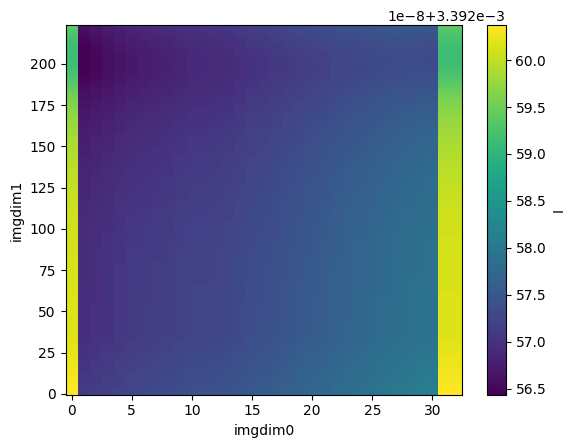

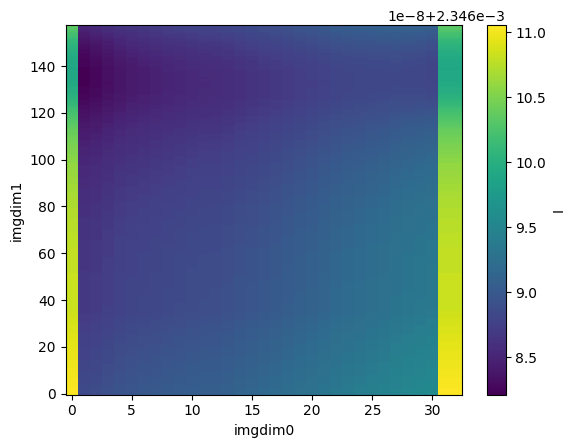

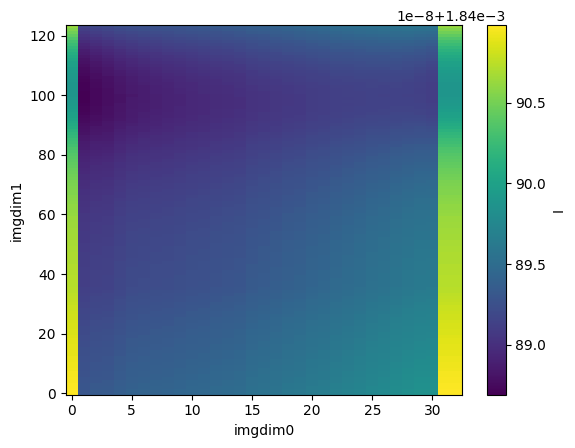

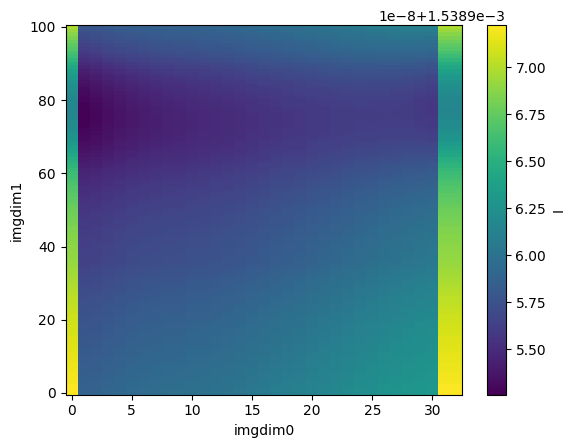

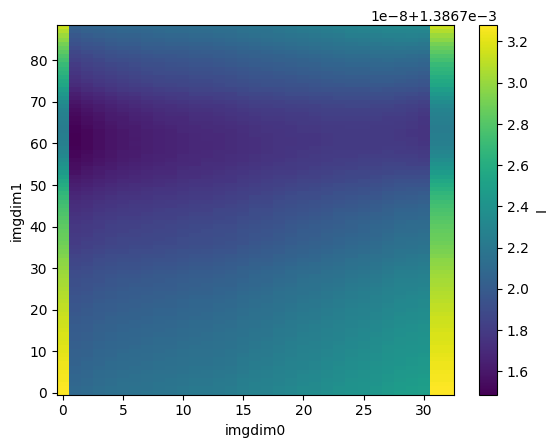

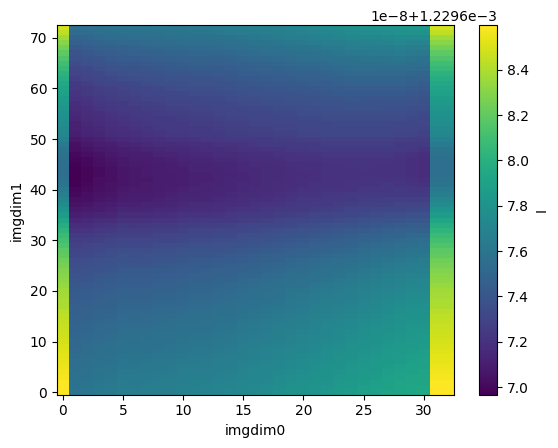

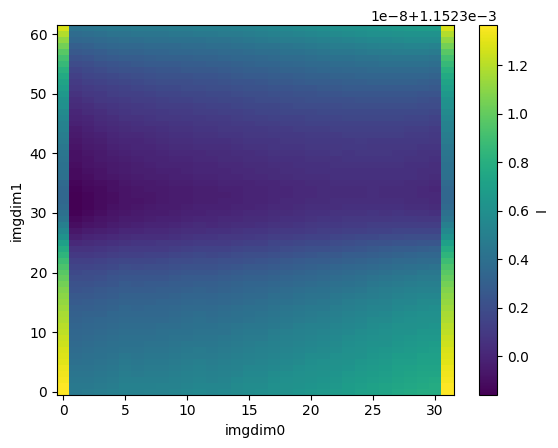

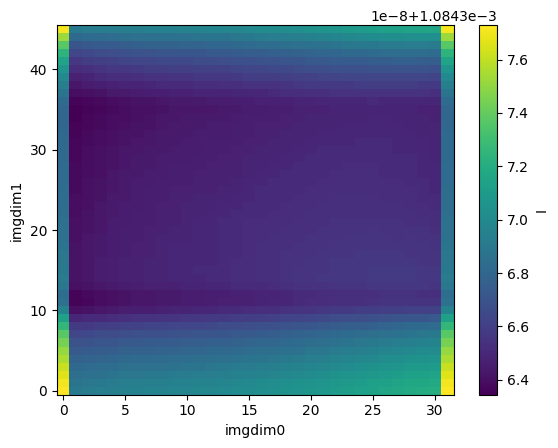

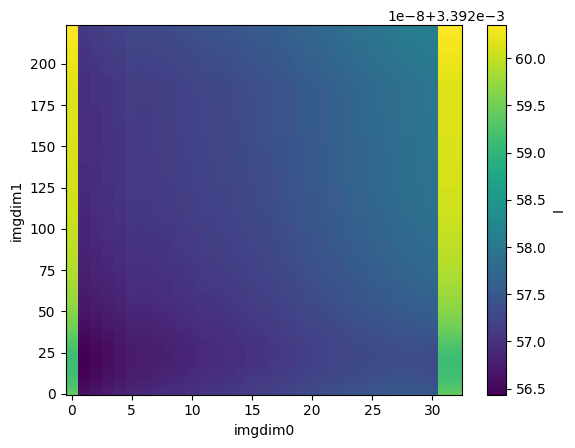

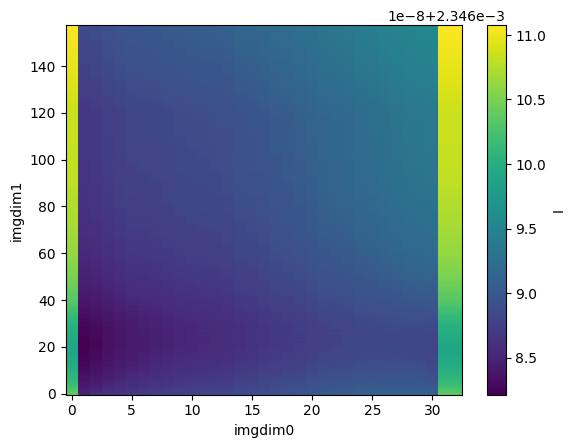

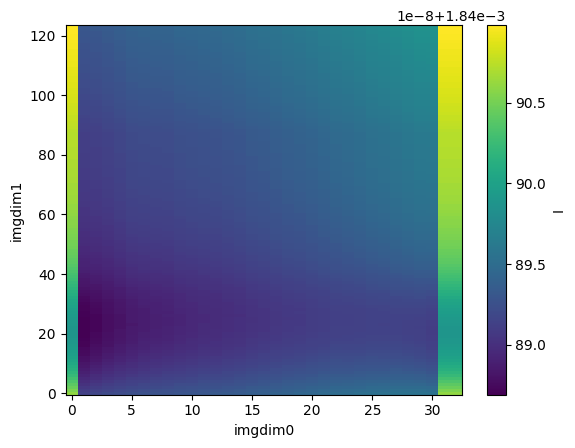

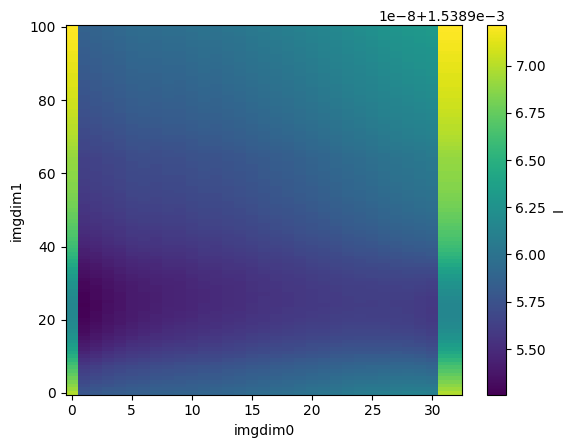

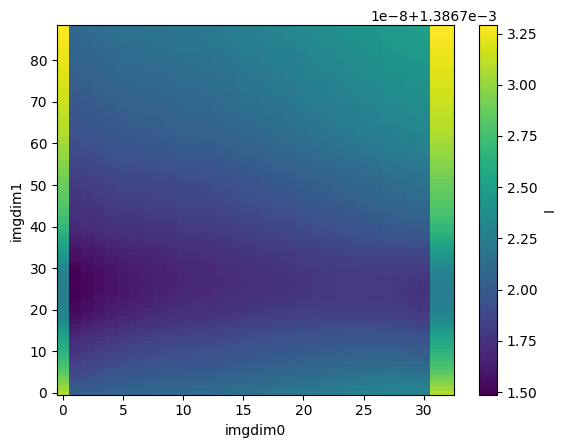

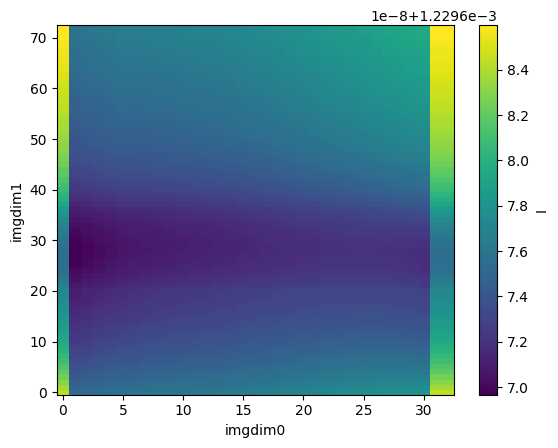

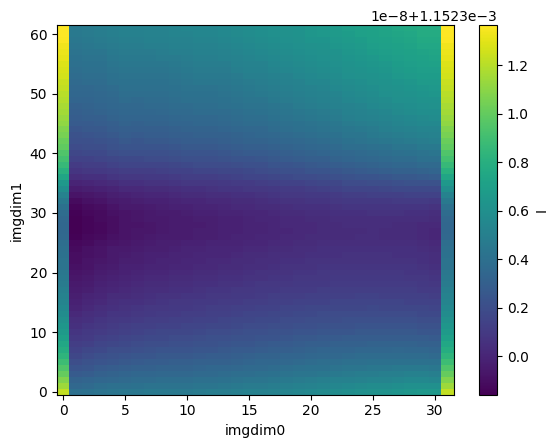

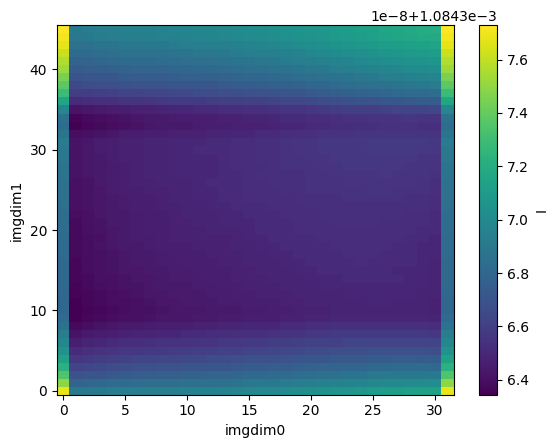

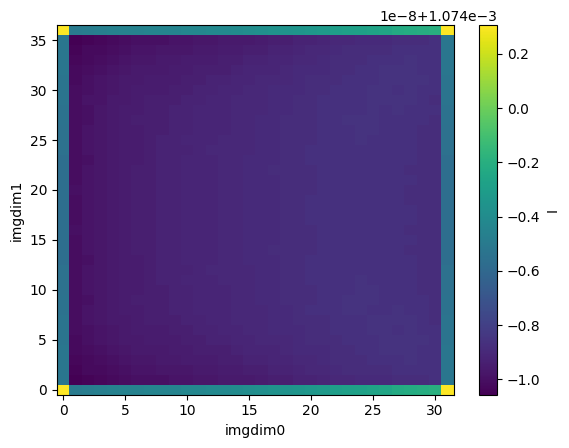

In [13]:
state_gen(x0)
#visualize the initial state
forward_sensors.get_measurements(solvers_reconstruct)

for instrument in forward_sensors:
    for im in forward_sensors.get_images(instrument):
        py.figure()
        im.I.T.plot()

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9064     M =           10

At X0      9037 variables are exactly at the bounds

At iterate    0    f=  5.89971D+04    |proj g|=  6.17673D+01
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.145  0.935E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -2.434  0.875E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -3.978  0.638E-01    31993    78.96  0.308   [Radiance 0.660 micron]
     4  -4.201  0.292E-01    32090    79.27  0.310   [Radiance 0.660 micron]
 ! Iterations:      4     Final Criterion:  0.000063   [Radiance 0.660 micron]

At

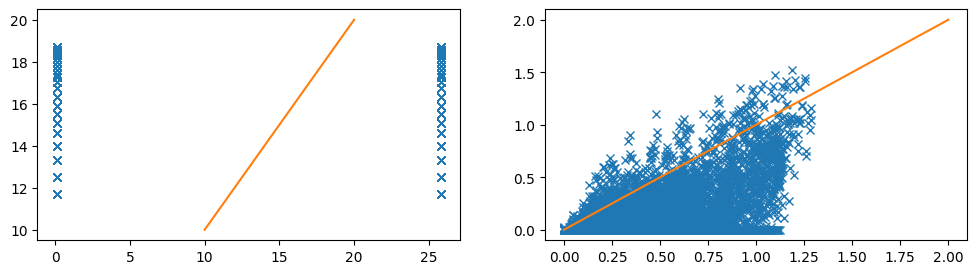

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.871  0.148E+00    31968    78.14  0.305   [Radiance 0.660 micron]
     2  -1.793  0.142E+00    31968    78.14  0.305   [Radiance 0.660 micron]
     3  -2.863  0.126E+00    31994    78.28  0.306   [Radiance 0.660 micron]
     4  -3.722  0.502E-01    32103    78.68  0.307   [Radiance 0.660 micron]
     5  -4.455  0.299E-01    32221    79.09  0.309   [Radiance 0.660 micron]
 ! Iterations:      5     Final Criterion:  0.000035   [Radiance 0.660 micron]

At iterate    2    f=  5.28152D+04    |proj g|=  6.39296D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.871  0.148E+00    31968    78.14  0.305   [Radiance 0.660 micron]
     2  -1.793  0.142E+00    31968    78.14  0.305   [Radiance 0.660 micron]
     3  -2.863  0.126E+00    31994    78.28  0.306   [Radiance 0.660 micron]
     4  -3.722  0.502E-01    32103    78.68  0.307   [Radiance 0.660 micron]
     5  -4.455  0.

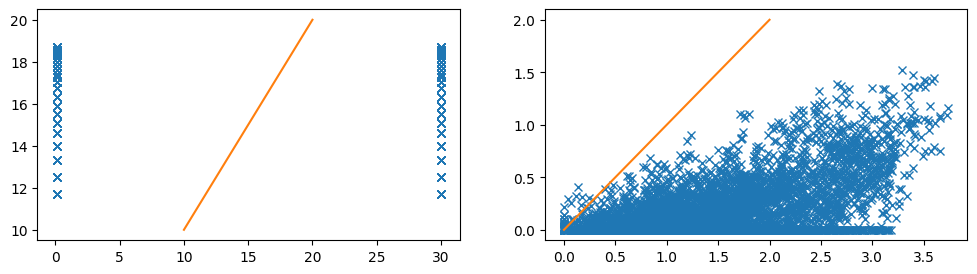


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9064      2      3     58     0    56   6.393D+00   5.282D+04
  F =   52815.201452331414     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [14]:
import warnings
optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True})
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 2
result = optimizer.minimize(x0)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.871  0.148E+00    31968    78.14  0.305   [Radiance 0.660 micron]
     2  -1.793  0.142E+00    31968    78.14  0.305   [Radiance 0.660 micron]
     3  -2.863  0.126E+00    31994    78.28  0.306   [Radiance 0.660 micron]
     4  -3.722  0.502E-01    32103    78.68  0.307   [Radiance 0.660 micron]
     5  -4.455  0.299E-01    32221    79.09  0.309   [Radiance 0.660 micron]
 ! Iterations:      5     Final Criterion:  0.000035   [Radiance 0.660 micron]
-2.282166976516337
3.492907213515384


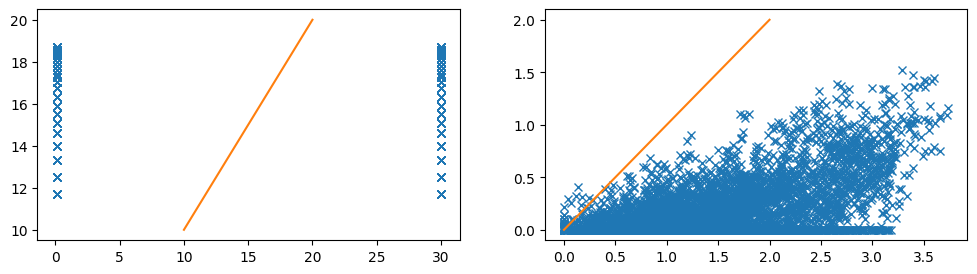

{'None': None}

In [15]:
plot(optimizer)

In [16]:
print(solvers_reconstruct)

SolversDict([(0.66, <at3d.solver.RTE object at 0x7fa2292120e0>)])


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.871  0.148E+00    31968    78.14  0.305   [Radiance 0.660 micron]
     2  -1.793  0.142E+00    31968    78.14  0.305   [Radiance 0.660 micron]
     3  -2.863  0.126E+00    31994    78.28  0.306   [Radiance 0.660 micron]
     4  -3.722  0.502E-01    32103    78.68  0.307   [Radiance 0.660 micron]
     5  -4.455  0.299E-01    32221    79.09  0.309   [Radiance 0.660 micron]
 ! Iterations:      5     Final Criterion:  0.000035   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9064     M =           10

At X0       116 variables are exactly at the bounds

At iterate    0    f=  5.28152D+04    |proj g|=  6.39296D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.832  0.173E+00    31968    78.28  0.306   [Radiance 0.660 micron]
     2  -1.692  0.163E+00    31968    78.28  0.306   [Radiance 0.660 micron]
     

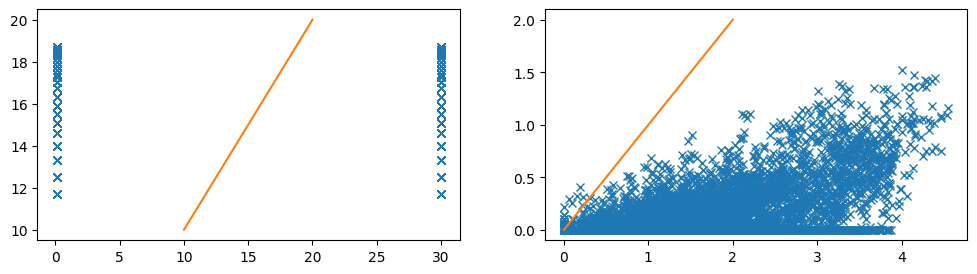

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.681  0.238E+00    31968    76.42  0.299   [Radiance 0.660 micron]
     2  -1.187  0.241E+00    31968    76.42  0.299   [Radiance 0.660 micron]
     3  -1.599  0.243E+00    31968    76.42  0.299   [Radiance 0.660 micron]
     4  -1.895  0.174E+00    31976    76.47  0.299   [Radiance 0.660 micron]
     5  -2.416  0.115E+00    32040    76.72  0.300   [Radiance 0.660 micron]
     6  -2.611  0.631E-01    32480    78.82  0.308   [Radiance 0.660 micron]
     7  -2.632  0.410E-01    33332    82.47  0.322   [Radiance 0.660 micron]
     8  -2.930  0.326E-01    34061    85.45  0.334   [Radiance 0.660 micron]
     9  -3.156  0.300E-01    34445    87.05  0.340   [Radiance 0.660 micron]
    10  -3.619  0.301E-01    34445    87.05  0.340   [Radiance 0.660 micron]
    11  -3.845  0.301E-01    34445    87.05  0.340   [Radiance 0.660 micron]
    12  -4.049  0.301E-01    34445    87.05  0.340   [Radiance 0.660 micron]
 !

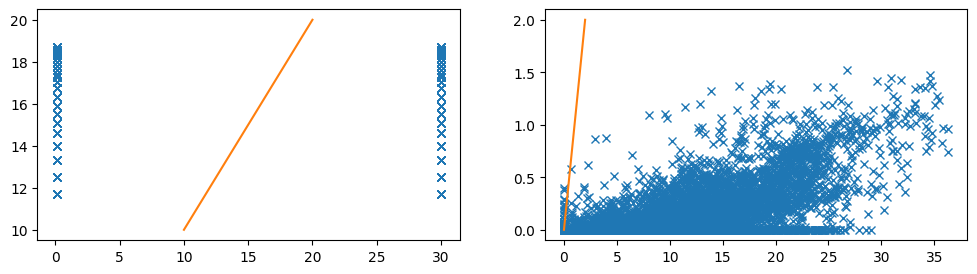

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.673  0.173E+00    31968    75.42  0.295   [Radiance 0.660 micron]
     2  -1.174  0.191E+00    31968    75.42  0.295   [Radiance 0.660 micron]
     3  -1.574  0.191E+00    31968    75.42  0.295   [Radiance 0.660 micron]
     4  -1.862  0.155E+00    31992    75.56  0.295   [Radiance 0.660 micron]
     5  -2.348  0.102E+00    32108    76.18  0.298   [Radiance 0.660 micron]
     6  -2.563  0.614E-01    32696    78.86  0.308   [Radiance 0.660 micron]
     7  -2.600  0.419E-01    33674    83.30  0.325   [Radiance 0.660 micron]
     8  -2.883  0.339E-01    34823    88.43  0.345   [Radiance 0.660 micron]
     9  -3.020  0.300E-01    35728    92.18  0.360   [Radiance 0.660 micron]
    10  -3.444  0.301E-01    35728    92.18  0.360   [Radiance 0.660 micron]
    11  -3.660  0.301E-01    35728    92.18  0.360   [Radiance 0.660 micron]
    12  -3.845  0.301E-01    35728    92.18  0.360   [Radiance 0.660 micron]
  

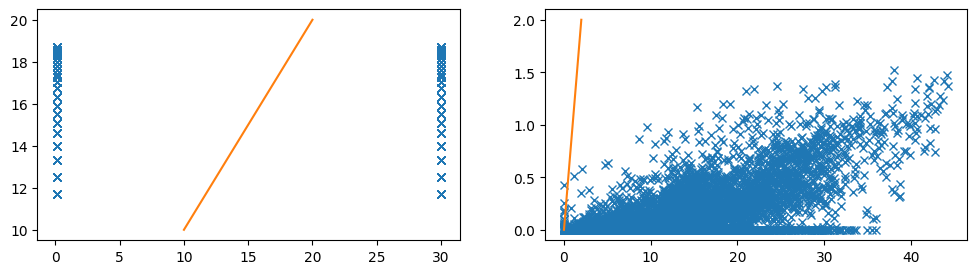

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.674  0.204E+00    31968    71.49  0.279   [Radiance 0.660 micron]
     2  -1.176  0.231E+00    31968    71.49  0.279   [Radiance 0.660 micron]
     3  -1.554  0.237E+00    31968    71.49  0.279   [Radiance 0.660 micron]
     4  -1.831  0.187E+00    32000    71.68  0.280   [Radiance 0.660 micron]
     5  -2.309  0.119E+00    32212    72.80  0.284   [Radiance 0.660 micron]
     6  -2.480  0.690E-01    33017    76.65  0.299   [Radiance 0.660 micron]
     7  -2.473  0.468E-01    34654    83.96  0.328   [Radiance 0.660 micron]
     8  -2.759  0.387E-01    36143    90.47  0.353   [Radiance 0.660 micron]
     9  -2.755  0.300E-01    38917   101.00  0.395   [Radiance 0.660 micron]
    10  -3.177  0.300E-01    38973   101.18  0.395   [Radiance 0.660 micron]
    11  -3.427  0.300E-01    38973   101.18  0.395   [Radiance 0.660 micron]
    12  -3.592  0.300E-01    38973   101.18  0.395   [Radiance 0.660 micron]
  

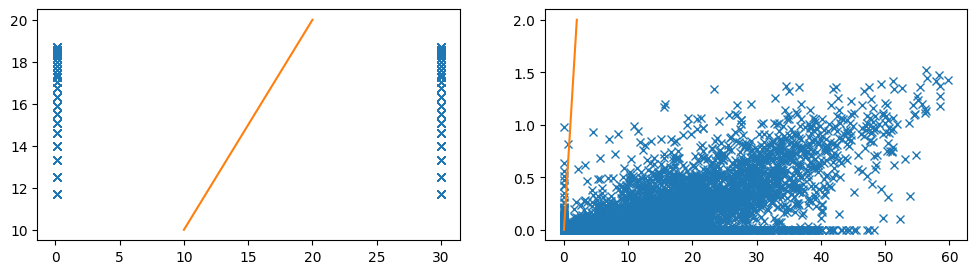

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.671  0.228E+00    31968    69.75  0.272   [Radiance 0.660 micron]
     2  -1.176  0.252E+00    31968    69.75  0.272   [Radiance 0.660 micron]
     3  -1.530  0.258E+00    31968    69.75  0.272   [Radiance 0.660 micron]
     4  -1.792  0.205E+00    32036    70.15  0.274   [Radiance 0.660 micron]
     5  -2.262  0.131E+00    32327    71.71  0.280   [Radiance 0.660 micron]
     6  -2.390  0.752E-01    33548    77.55  0.303   [Radiance 0.660 micron]
     7  -2.409  0.521E-01    35824    87.78  0.343   [Radiance 0.660 micron]
     8  -2.663  0.428E-01    37665    95.11  0.372   [Radiance 0.660 micron]
     9  -2.698  0.325E-01    41419   107.92  0.422   [Radiance 0.660 micron]
    10  -2.834  0.300E-01    43049   112.53  0.440   [Radiance 0.660 micron]
    11  -3.162  0.300E-01    43087   112.63  0.440   [Radiance 0.660 micron]
    12  -3.345  0.302E-01    43087   112.63  0.440   [Radiance 0.660 micron]
  

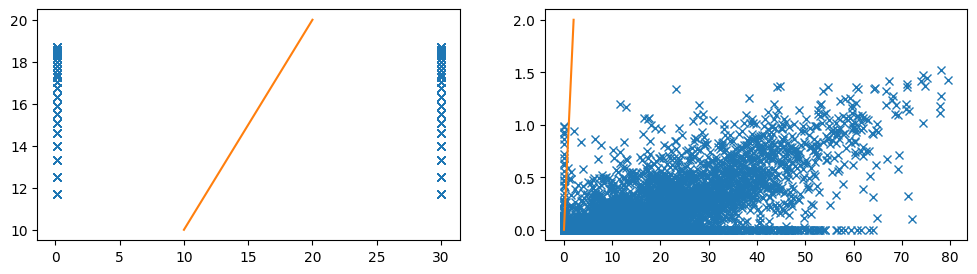

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.669  0.282E+00    31968    67.14  0.262   [Radiance 0.660 micron]
     2  -1.178  0.306E+00    31968    67.14  0.262   [Radiance 0.660 micron]
     3  -1.488  0.312E+00    31968    67.14  0.262   [Radiance 0.660 micron]
     4  -1.719  0.252E+00    32057    67.67  0.264   [Radiance 0.660 micron]
     5  -2.167  0.161E+00    32389    69.48  0.271   [Radiance 0.660 micron]
     6  -2.298  0.912E-01    34098    77.64  0.303   [Radiance 0.660 micron]
     7  -2.316  0.620E-01    36925    90.03  0.352   [Radiance 0.660 micron]
     8  -2.551  0.505E-01    39245    98.47  0.385   [Radiance 0.660 micron]
     9  -2.587  0.381E-01    44308   114.19  0.446   [Radiance 0.660 micron]
    10  -2.654  0.322E-01    48992   125.31  0.489   [Radiance 0.660 micron]
    11  -2.833  0.300E-01    51239   130.17  0.508   [Radiance 0.660 micron]
    12  -3.139  0.300E-01    51318   130.36  0.509   [Radiance 0.660 micron]
  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.665  0.228E+00    31968    76.48  0.299   [Radiance 0.660 micron]
     2  -1.171  0.251E+00    31968    76.48  0.299   [Radiance 0.660 micron]
     3  -1.525  0.258E+00    31968    76.48  0.299   [Radiance 0.660 micron]
     4  -1.788  0.205E+00    32036    76.86  0.300   [Radiance 0.660 micron]
     5  -2.264  0.131E+00    32314    78.33  0.306   [Radiance 0.660 micron]
     6  -2.398  0.752E-01    33552    84.16  0.329   [Radiance 0.660 micron]
     7  -2.429  0.518E-01    35873    94.35  0.369   [Radiance 0.660 micron]
     8  -2.665  0.421E-01    37861   102.06  0.399   [Radiance 0.660 micron]
     9  -2.695  0.322E-01    41595   114.25  0.446   [Radiance 0.660 micron]
    10  -2.851  0.300E-01    43051   118.37  0.462   [Radiance 0.660 micron]
    11  -3.173  0.300E-01    43093   118.48  0.463   [Radiance 0.660 micron]
    12  -3.357  0.300E-01    43093   118.48  0.463   [Radiance 0.660 micron]
  

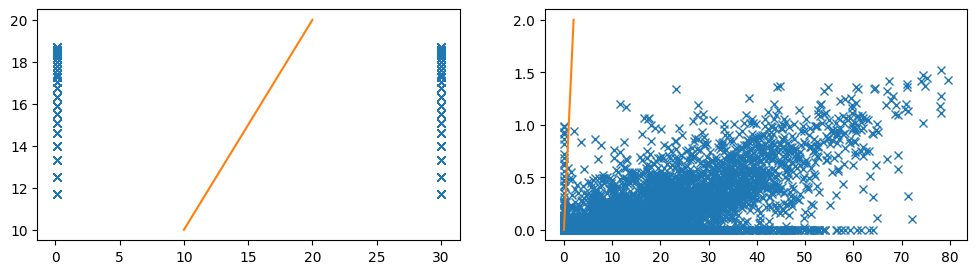

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.667  0.228E+00    31968    74.14  0.290   [Radiance 0.660 micron]
     2  -1.173  0.245E+00    31968    74.14  0.290   [Radiance 0.660 micron]
     3  -1.526  0.252E+00    31968    74.14  0.290   [Radiance 0.660 micron]
     4  -1.788  0.200E+00    32044    74.57  0.291   [Radiance 0.660 micron]
     5  -2.260  0.129E+00    32346    76.21  0.298   [Radiance 0.660 micron]
     6  -2.393  0.746E-01    33610    82.13  0.321   [Radiance 0.660 micron]
     7  -2.422  0.517E-01    35930    92.44  0.361   [Radiance 0.660 micron]
     8  -2.655  0.422E-01    37915   100.18  0.391   [Radiance 0.660 micron]
     9  -2.697  0.325E-01    41556   112.23  0.438   [Radiance 0.660 micron]
    10  -2.856  0.300E-01    43233   116.99  0.457   [Radiance 0.660 micron]
    11  -3.159  0.300E-01    43279   117.12  0.458   [Radiance 0.660 micron]
    12  -3.345  0.300E-01    43279   117.12  0.458   [Radiance 0.660 micron]
  

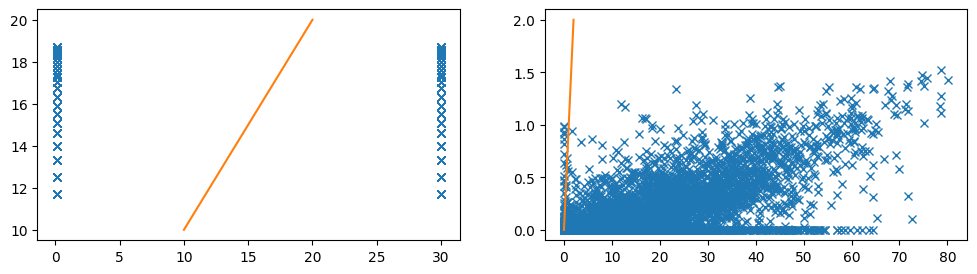

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.670  0.231E+00    31968    72.91  0.285   [Radiance 0.660 micron]
     2  -1.171  0.243E+00    31968    72.91  0.285   [Radiance 0.660 micron]
     3  -1.518  0.246E+00    31968    72.91  0.285   [Radiance 0.660 micron]
     4  -1.776  0.201E+00    32086    73.58  0.287   [Radiance 0.660 micron]
     5  -2.243  0.130E+00    32420    75.33  0.294   [Radiance 0.660 micron]
     6  -2.382  0.757E-01    33894    82.17  0.321   [Radiance 0.660 micron]
     7  -2.405  0.525E-01    36441    93.33  0.365   [Radiance 0.660 micron]
     8  -2.631  0.430E-01    38584   101.14  0.395   [Radiance 0.660 micron]
     9  -2.674  0.334E-01    42541   113.35  0.443   [Radiance 0.660 micron]
    10  -2.791  0.300E-01    44915   119.57  0.467   [Radiance 0.660 micron]
    11  -3.103  0.300E-01    44983   119.74  0.468   [Radiance 0.660 micron]
    12  -3.305  0.301E-01    44983   119.74  0.468   [Radiance 0.660 micron]
  

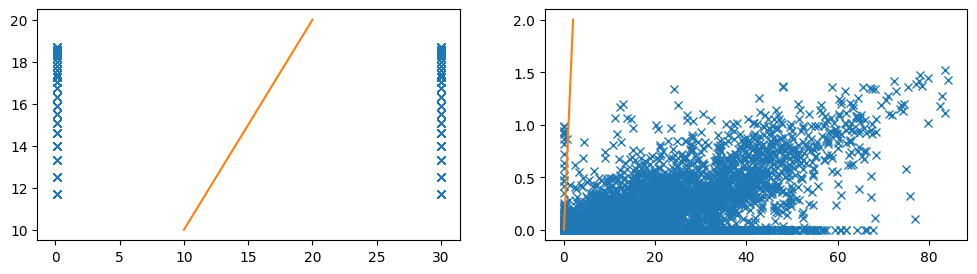

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.673  0.344E+00    31968    69.93  0.273   [Radiance 0.660 micron]
     2  -1.168  0.332E+00    31968    69.93  0.273   [Radiance 0.660 micron]
     3  -1.497  0.330E+00    31968    69.93  0.273   [Radiance 0.660 micron]
     4  -1.743  0.269E+00    32005    70.15  0.274   [Radiance 0.660 micron]
     5  -2.220  0.167E+00    32280    71.55  0.280   [Radiance 0.660 micron]
     6  -2.332  0.900E-01    33847    78.91  0.308   [Radiance 0.660 micron]
     7  -2.282  0.604E-01    36533    90.42  0.353   [Radiance 0.660 micron]
     8  -2.600  0.515E-01    38261    96.67  0.378   [Radiance 0.660 micron]
     9  -2.523  0.370E-01    43880   113.42  0.443   [Radiance 0.660 micron]
    10  -2.718  0.333E-01    46487   120.04  0.469   [Radiance 0.660 micron]
    11  -2.690  0.300E-01    49397   126.43  0.494   [Radiance 0.660 micron]
    12  -3.119  0.300E-01    49527   126.67  0.495   [Radiance 0.660 micron]
  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.665  0.233E+00    31968    76.27  0.298   [Radiance 0.660 micron]
     2  -1.167  0.243E+00    31968    76.27  0.298   [Radiance 0.660 micron]
     3  -1.516  0.246E+00    31968    76.27  0.298   [Radiance 0.660 micron]
     4  -1.773  0.201E+00    32087    76.93  0.301   [Radiance 0.660 micron]
     5  -2.244  0.130E+00    32420    78.66  0.307   [Radiance 0.660 micron]
     6  -2.380  0.758E-01    33895    85.47  0.334   [Radiance 0.660 micron]
     7  -2.416  0.526E-01    36448    96.56  0.377   [Radiance 0.660 micron]
     8  -2.629  0.427E-01    38690   104.59  0.409   [Radiance 0.660 micron]
     9  -2.676  0.333E-01    42571   116.32  0.454   [Radiance 0.660 micron]
    10  -2.795  0.300E-01    44937   122.43  0.478   [Radiance 0.660 micron]
    11  -3.107  0.300E-01    45005   122.61  0.479   [Radiance 0.660 micron]
    12  -3.312  0.301E-01    45005   122.61  0.479   [Radiance 0.660 micron]
  

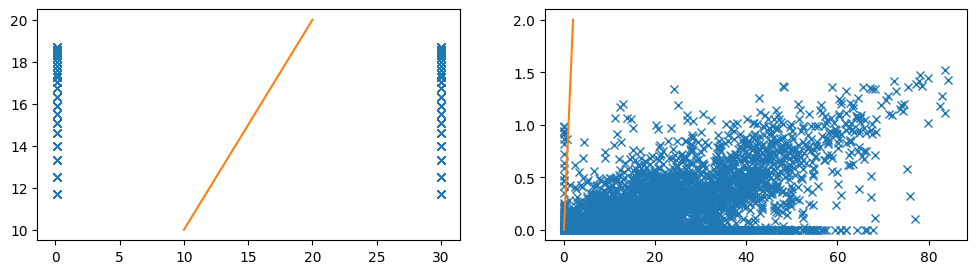

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.667  0.241E+00    31968    74.10  0.289   [Radiance 0.660 micron]
     2  -1.170  0.244E+00    31968    74.10  0.289   [Radiance 0.660 micron]
     3  -1.515  0.246E+00    31968    74.10  0.289   [Radiance 0.660 micron]
     4  -1.772  0.202E+00    32091    74.79  0.292   [Radiance 0.660 micron]
     5  -2.238  0.131E+00    32427    76.53  0.299   [Radiance 0.660 micron]
     6  -2.377  0.761E-01    33886    83.33  0.326   [Radiance 0.660 micron]
     7  -2.403  0.528E-01    36459    94.59  0.369   [Radiance 0.660 micron]
     8  -2.631  0.432E-01    38599   102.34  0.400   [Radiance 0.660 micron]
     9  -2.667  0.334E-01    42602   114.53  0.447   [Radiance 0.660 micron]
    10  -2.785  0.300E-01    45087   120.85  0.472   [Radiance 0.660 micron]
    11  -3.090  0.300E-01    45155   121.04  0.473   [Radiance 0.660 micron]
    12  -3.303  0.301E-01    45155   121.04  0.473   [Radiance 0.660 micron]
  

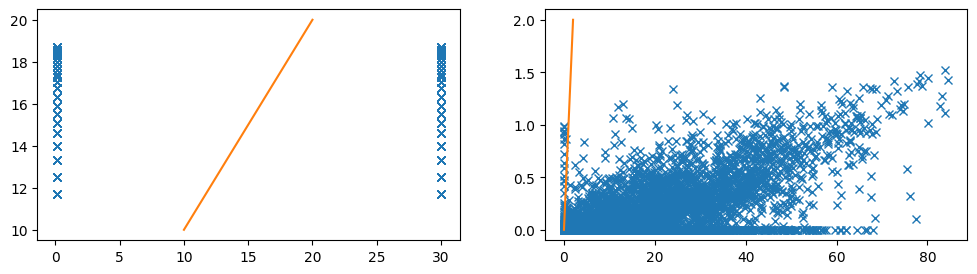


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9064     10     31   1993     0   572   1.512D+00   3.585D+03
  F =   3584.5876069445785     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [17]:
final_state = state_gen.get_state()
import warnings
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 10
result = optimizer.minimize(final_state)

In [18]:
unknown_scatterer_indices = list(solvers_reconstruct.values())[0]._unknown_scatterer_indices - 1
unknown_scatterer_names = np.array(list(list(solvers_reconstruct.values())[0].medium.keys()))[unknown_scatterer_indices]
print(unknown_scatterer_names)
#print(objective_function(state_gen.get_state())[0].shape)
grads = (objective_function(state_gen.get_state())[1])

['cloud' 'cloud']
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.667  0.241E+00    31968    74.10  0.289   [Radiance 0.660 micron]
     2  -1.170  0.244E+00    31968    74.10  0.289   [Radiance 0.660 micron]
     3  -1.515  0.246E+00    31968    74.10  0.289   [Radiance 0.660 micron]
     4  -1.772  0.202E+00    32091    74.79  0.292   [Radiance 0.660 micron]
     5  -2.238  0.131E+00    32427    76.53  0.299   [Radiance 0.660 micron]
     6  -2.377  0.761E-01    33886    83.33  0.326   [Radiance 0.660 micron]
     7  -2.403  0.528E-01    36459    94.59  0.369   [Radiance 0.660 micron]
     8  -2.631  0.432E-01    38599   102.34  0.400   [Radiance 0.660 micron]
     9  -2.667  0.334E-01    42602   114.53  0.447   [Radiance 0.660 micron]
    10  -2.785  0.300E-01    45087   120.85  0.472   [Radiance 0.660 micron]
    11  -3.090  0.300E-01    45155   121.04  0.473   [Radiance 0.660 micron]
    12  -3.303  0.301E-01    45155   121.04  0.473   [Radianc

In [19]:
print(grads[9000:])

[-0.11685915 -0.11069028 -0.05786039  0.04012313  0.03234062 -0.16526528
 -0.12345863 -0.11326128 -0.10468844 -0.05916016  0.03688419  0.03542711
 -0.06389649 -0.12706234 -0.10818409 -0.09383762 -0.05251589  0.03079939
  0.03600879 -0.13542809 -0.10486836 -0.08247833 -0.04252182  0.02132502
  0.02747294 -0.07866955 -0.05158852 -0.1251811  -0.08649988 -0.05485311
 -0.16140284 -0.12091037 -0.0823494  -0.04620494 -0.04514643 -0.15379251
 -0.12095618 -0.08267385 -0.04430172 -0.03972766 -0.20432994 -0.15209843
 -0.12007184 -0.08202769 -0.04236915 -0.03350254 -0.08365988 -0.15322643
 -0.11930021 -0.08277893 -0.04248809 -0.03171108 -0.08085744 -0.16109836
 -0.12032123 -0.08336478 -0.04503838 -0.03343046 -0.12493309 -0.08660271
 -0.04830838 -0.03757433 -0.09552085 -0.06277553]


In [22]:
# loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
            # sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
            # gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
            # uncertainty_kwargs={'add_noise': False})()
print(gradient["gradient"][:,:,:,0].std())
print(gradient["gradient"][:,:,:,0].mean())
print(gradient["gradient"][:,:,:,0].max())
print(gradient["gradient"][:,:,:,0].min())

print(gradient["gradient"][:,:,:,1].std())
print(gradient["gradient"][:,:,:,1].mean())
print(gradient["gradient"][:,:,:,1].max())
print(gradient["gradient"][:,:,:,1].min())

<xarray.DataArray 'gradient' ()>
array(0.00114266)
Coordinates:
    wavelength        float64 0.66
    derivative_index  object ('cloud', 'reff')
<xarray.DataArray 'gradient' ()>
array(-0.00035942)
Coordinates:
    wavelength        float64 0.66
    derivative_index  object ('cloud', 'reff')
<xarray.DataArray 'gradient' ()>
array(0.01194613)
Coordinates:
    wavelength        float64 0.66
    derivative_index  object ('cloud', 'reff')
<xarray.DataArray 'gradient' ()>
array(-0.01469164)
Coordinates:
    wavelength        float64 0.66
    derivative_index  object ('cloud', 'reff')
<xarray.DataArray 'gradient' ()>
array(0.20353923)
Coordinates:
    wavelength        float64 0.66
    derivative_index  object ('cloud', 'density')
<xarray.DataArray 'gradient' ()>
array(0.04900074)
Coordinates:
    wavelength        float64 0.66
    derivative_index  object ('cloud', 'density')
<xarray.DataArray 'gradient' ()>
array(3.96768672)
Coordinates:
    wavelength        float64 0.66
    derivative_in

In [43]:
# plot(optimizer)
print(solvers[.66].medium['cloud'].extinction.min)

<xarray.DataArray 'extinction' ()>
array(0.)


In [3]:
# plot(optimizer)
print(solvers[.66].medium['cloud'].density.shape)

NameError: name 'solvers' is not defined

In [1]:
grads = optimizer.objective(optimizer._state)[1]
print(grads[9037:].mean())
print(grads[9037:].std())
print(grads[:9037].mean())
print(grads[:9037].std())

NameError: name 'optimizer' is not defined

NameError: name 'solvers' is not defined